# Ambiguity and discrepancy

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import matplotlib.patches as plt_patches
plt.style.use('seaborn')
%matplotlib inline

import numpy as np
import sklearn.metrics as sk_metrics

import itertools
import pickle
import sys

In [2]:
! mkdir -p run_cache/ambiguity

In [3]:
def progress_bar(step, total, preamble=''):
    sys.stdout.write('\r')
    sys.stdout.write("%s[%-99s] %2.d%%" % (preamble, '='*step, total))
    sys.stdout.flush()

In [4]:
STORE_AMBIGUITY = False

delta = 0  # tolerance (delta) on predictive performance

save_fig = True
folds = range(0, 10)

# Testcase
task_id, flow_id, x_precision = 31, 66, .05  # x-axis plot step space

# Fairness
## Top-performing pipeline for each data set (i.e., task)
### Supervised Classification on credit-approval # Gradient Boosting
# task_id, flow_id, x_precision = 29, 12736, .02
### Supervised Classification on credit-g # Ranger Classifier
# task_id, flow_id, x_precision = 31, 6794, .02
### Supervised Classification on adult # Boosting with Decision Trees
# task_id, flow_id, x_precision = 7592, 6970, .02

In [5]:
task_flow = {}

with open(f'./run_cache/{task_id}/{task_id}_{flow_id}.pickle', 'br') as f:
    dict_ = pickle.load(f)

    labels = dict_['labels']
    predictions = dict_['runs']

In [6]:
per_fold_metric = dict()

for fold_id in folds:
    per_fold_metric[fold_id] = dict()

    one_value = np.unique(labels[fold_id])
    assert one_value.shape[0] == 2
    one_value = one_value[0]

    for y_ in predictions[flow_id][fold_id]:
        y = labels[fold_id].astype(y_.dtype)

        # get performance
        y_acc = sk_metrics.accuracy_score(y, y_)
        if delta:
            y_acc = np.around(y_acc, decimals=delta)

        # get binary representation
        y_comp = y_ == one_value
        
        if y_acc in per_fold_metric[fold_id]:
            per_fold_metric[fold_id][y_acc].append(y_comp)
        else:
            per_fold_metric[fold_id][y_acc] = [y_comp]

In [7]:
ambiguity = dict()
ambiguity_count = dict()
discrepancy = dict()

for fold_id in folds:
    ambiguity[fold_id] = {'split': {}}
    ambiguity_count[fold_id] = {}
    discrepancy[fold_id] = {}

    this_fold = per_fold_metric[fold_id]
    metric_values = sorted(this_fold.keys())[::-1]

    prog_max = len(metric_values)
    for prog_i, i in enumerate(metric_values):
        ambiguity_count[fold_id][i] = np.vstack(this_fold[i]).shape[0]

        amb = np.logical_not(np.logical_or(
            np.all(np.vstack(this_fold[i]), axis=0),
            np.all(np.logical_not(np.asarray(this_fold[i])), axis=0)
        ))
        ambiguity[fold_id]['split'][i] = amb.sum()

        discrepancy[fold_id][i] = []
        if task_id == 31 and len(this_fold[i]) > 500:  # 500 -> 15 minutes
            np.random.seed(42)
            idx_ = np.random.choice(len(this_fold[i]), size=500, replace=False).tolist()
            this_fold_ = np.asarray(this_fold[i])[idx_, :].tolist()
        else:
            this_fold_ = this_fold[i]
        for y_1, y_2 in itertools.combinations(this_fold_, 2):
            dis = np.logical_not(np.logical_or(
                np.all(np.vstack([y_1, y_2]), axis=0),
                np.all(np.logical_not(np.asarray([y_1, y_2])), axis=0)
            ))
            discrepancy[fold_id][i].append(dis.sum())
        prog_ = int(100*prog_i/prog_max)
        progress_bar(prog_, prog_, f'Fold: {fold_id}: ')
    progress_bar(100, 100, f'Fold: {fold_id}: ')
    print('')

    ambiguity[fold_id]['total'] = amb.shape[0]

    if STORE_AMBIGUITY:
        with open(f'./run_cache/ambiguity/ambiguity_{task_id}_{flow_id}_{fold_id}.pkl', 'wb') as f:
            pickle.dump(ambiguity, f)

Fold: 0: [====================================================================================================] 100%
Fold: 1: [====================================================================================================] 100%
Fold: 2: [====================================================================================================] 100%
Fold: 3: [====================================================================================================] 100%
Fold: 4: [====================================================================================================] 100%
Fold: 5: [====================================================================================================] 100%
Fold: 6: [====================================================================================================] 100%
Fold: 7: [====================================================================================================] 100%
Fold: 8: [======================================================

In [8]:
plotlines = []
plotlines_count = []
plotlines_discrepancy = []
plotlines_discrepancy_box = []

for fold_id in folds:
    total = ambiguity[fold_id]['total']
    split = ambiguity[fold_id]['split']

    metrics = sorted(list(split.keys()))[::-1]

    props = [split[i]/total for i in metrics]
    plotlines.append((metrics, props))

    split_count = ambiguity_count[fold_id]

    props_counts = [split_count[i] for i in metrics]
    plotlines_count.append((metrics, props_counts))

    discs = []
    for m in metrics:
        discs += [(m, i/total) for i in discrepancy[fold_id][m]]
    plotlines_discrepancy.append(np.asarray(discs))

    plotlines_discrepancy_box.append(
        {m: [i/total for i in discrepancy[fold_id][m]] for m in metrics})

In [9]:
# colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

cc = plt.get_cmap('tab10')  # Set3
colours = [plt_colors.rgb2hex(cc(i)) for i in range(cc.N)]

## Ambiguity

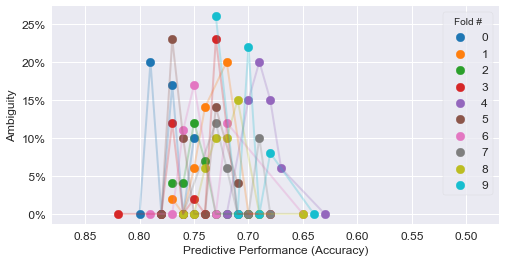

In [10]:
if task_id == 7592 and delta in (0, 3):
    figsize = (5, 4)
    _old_x_precision = x_precision
    x_precision = .02
else:
    figsize = (8, 4)
    _old_x_precision = x_precision
    x_precision = .05
f = plt.figure(figsize=figsize)

x_range = set()
for (x, y), fold_id, c in zip(plotlines, folds, colours):
    x_range = x_range.union(x)
    plt.plot(x, y, color=c, alpha=.25, lw=2)
    plt.scatter(x, y, color=c, label=fold_id, s=75)

if x_precision:
    x_range_min, x_range_max = min(x_range), max(x_range)
    if task_id == 29: x_range_min, x_range_max = .45, .96
    if task_id == 31: x_range_min, x_range_max = .50, .91
    if task_id == 7592: x_range_min, x_range_max = .70, .91
    if task_id == 7592 and delta in (0, 3): x_range_min, x_range_max = .78, .89
    plt.xticks(
        np.arange(x_range_min, x_range_max, x_precision)
    )
    # plt.xlim((min(x_range),
    #           max(x_range)))
    if task_id == 29: plt.xlim((.4, 1))
    if task_id == 31: plt.xlim((.47, .88))
    if task_id == 7592: plt.xlim((.68, .92))
    if task_id == 7592 and delta in (0, 3): plt.xlim((.76, .9))

# plt.yticks(
#     np.arange(0, .9, .2)
# )

f.axes[0].invert_xaxis()
f.axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, loc: f'{100*val:2.0f}%'))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Predictive Performance (Accuracy)', fontsize=12)
plt.ylabel('Ambiguity', fontsize=12)

plt.legend(title='Fold #', loc='upper right', frameon=True, framealpha=.75, fontsize=12)  # , facecolor='white'

if save_fig:
    plt.savefig(
        f'./figures/ambiguity_{task_id}_{flow_id}_{delta}.pdf',
        dpi=300,
        bbox_inches='tight',
        pad_inches=0)

x_precision = _old_x_precision

## Discrepancy

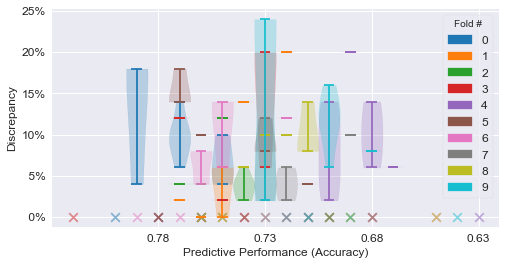

In [11]:
f = plt.figure(figsize=(8, 4))

x_range = set()
labels = []
for x_y, x_y_box, fold_id, c in zip(plotlines_discrepancy, plotlines_discrepancy_box, folds, colours):
    # if fold_id != 4:
    #     continue

    # scatter
    # x, y = x_y[:, 0], x_y[:, 1]
    # x_range = x_range.union(x)
    # plt.scatter(x, y, label=fold_id, marker='x', color=c, alpha=.25)

    # box
    metrics = sorted(list(x_y_box.keys()))
    data = [x_y_box[i] for i in metrics]
    x_range = x_range.union(metrics)
    # there won't be any discrepancy for just 1 model
    purge = []
    no_box = []
    for i, (m, d) in enumerate(zip(metrics, data)):
        if len(d) == 0:
            purge.append(i)
            no_box.append(m)
    for i in sorted(purge)[::-1]:
        del metrics[i]
        del data[i]
    #
    violins = plt.violinplot(data, metrics, widths=0.01)
    for pc in violins['bodies']:
        pc.set_color(c)
        # pc.set_facecolor('black')
        # pc.set_edgecolor('black')
        pc.set_alpha(.25)
    violins['cbars'].set_color(c)
    violins['cmins'].set_color(c)
    violins['cmaxes'].set_color(c)
    labels.append((plt_patches.Patch(color=c),  # pc.get_facecolor().flatten()
                   fold_id))
    #
    plt.scatter(no_box, [0]*len(no_box), marker='x', color=c, alpha=.5, s=75)

if x_precision:
    plt.xticks(
        np.arange(min(x_range), max(x_range), x_precision)
    )

f.axes[0].invert_xaxis()
f.axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, loc: f'{100*val:2.0f}%'))

plt.xlabel('Predictive Performance (Accuracy)', fontsize=12)
plt.ylabel('Discrepancy', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.legend(title='Fold #', loc='upper right', frameon=True, framealpha=.75)  # , facecolor='white'
plt.legend(*zip(*labels), title='Fold #', loc='upper right', frameon=True, framealpha=.75, fontsize=12)  # , facecolor='white'

if save_fig:
    plt.savefig(
        f'./figures/discrepancy_{task_id}_{flow_id}_{delta}.pdf',
        dpi=300,
        bbox_inches='tight',
        pad_inches=0)

## Run distribution

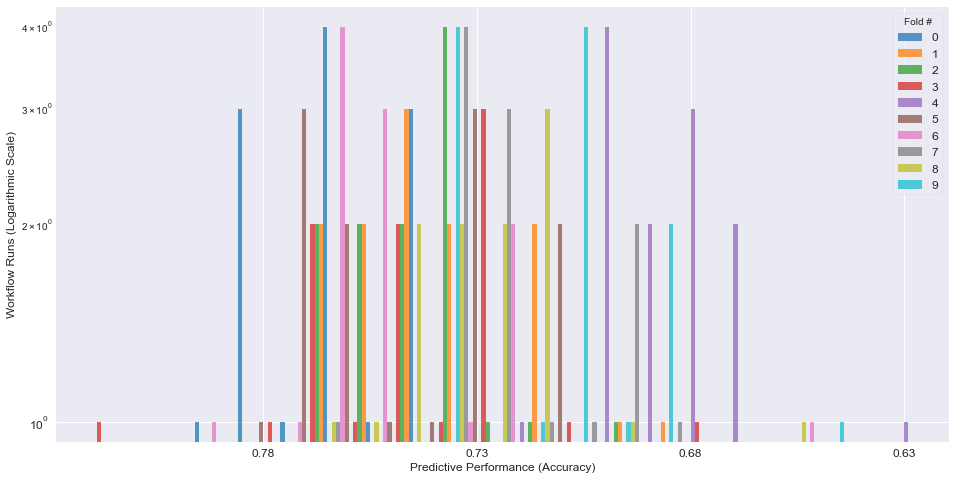

In [12]:
# f = plt.figure(figsize=(8, 4))
f = plt.figure(figsize=(16, 8))

shift = [-.005, -0.004, -0.003, -0.002, -0.001, 0, 0.001, 0.002, 0.003, 0.004]

for (x, y), fold_id, c in zip(plotlines_count, folds, colours):
    #plt.plot(x, y, color=c, alpha=.25)
    #plt.scatter(x, y, color=c, label=fold_id)
    plt.bar(np.asarray(x)+shift[int(fold_id)], y, width=0.001,
            align='edge',
            edgecolor=c, linewidth=0,
            label=fold_id,
            color=c, alpha=.75)

plt.yscale('log')

f.axes[0].invert_xaxis()
# f.axes[0].invert_yaxis()

if x_precision:
    plt.xticks(
        np.arange(min(x_range), max(x_range), x_precision)
    )

plt.xlabel('Predictive Performance (Accuracy)', fontsize=12)
plt.ylabel('Workflow Runs (Logarithmic Scale)', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Fold #', loc='upper right', frameon=True, framealpha=.75, fontsize=12)  # , facecolor='white'

if save_fig:
    plt.savefig(
        f'./figures/ambiguity_count_{task_id}_{flow_id}_{delta}.pdf',
        dpi=300,
        bbox_inches='tight',
        pad_inches=0)

## Ambiguity + Discrepancy + Run Distribution

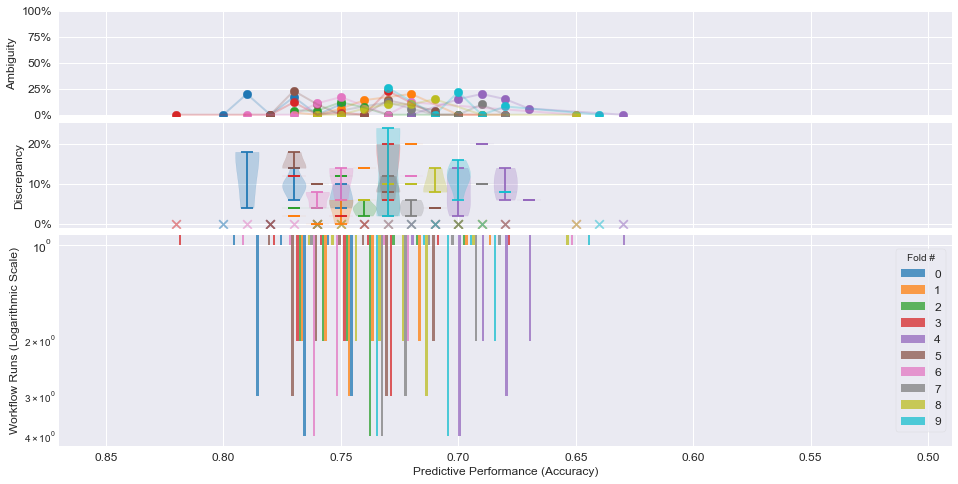

In [13]:
fig2, (axis21, axis211, axis22) = plt.subplots(  # change
    nrows=3, ncols=1, sharex=True,  # change 2
    figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1, 2]})

# fig1
x_range = set()
for (x, y), fold_id, c in zip(plotlines, folds, colours):
    x_range = x_range.union(x)
    axis21.plot(x, y, color=c, alpha=.25, lw=2)
    axis21.scatter(x, y, color=c, label=fold_id, s=75)

# if x_precision:
#     axis21.set_xticks(
#         np.arange(min(x_range), max(x_range), x_precision)
#     )

# axis21.invert_xaxis()
axis21.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, loc: f'{100*val:2.0f}%'))

if task_id == 31: axis21.set_yticks(np.arange(0, 1.01, .25))
axis21.tick_params(axis='y', labelsize=12)

axis21.set_ylabel('Ambiguity', fontsize=12)

#
# axis21.legend(title='Fold #', loc='upper right', frameon=True, framealpha=.75)  # , facecolor='white'
#

# fig 11
for x_y, x_y_box, fold_id, c in zip(plotlines_discrepancy, plotlines_discrepancy_box, folds, colours):
    # box
    metrics = sorted(list(x_y_box.keys()))
    data = [x_y_box[i] for i in metrics]
    x_range = x_range.union(metrics)
    # there won't be any discrepancy for just 1 model
    purge = []
    no_box = []
    for i, (m, d) in enumerate(zip(metrics, data)):
        if len(d) == 0:
            purge.append(i)
            no_box.append(m)
    for i in sorted(purge)[::-1]:
        del metrics[i]
        del data[i]
    #
    violins = axis211.violinplot(data, metrics, widths=0.01)
    for pc in violins['bodies']:
        pc.set_color(c)
        # pc.set_facecolor('black')
        # pc.set_edgecolor('black')
        pc.set_alpha(.25)
    violins['cbars'].set_color(c)
    violins['cmins'].set_color(c)
    violins['cmaxes'].set_color(c)
    #
    axis211.scatter(no_box, [0]*len(no_box), marker='x', color=c, alpha=.5, s=75)

# if x_precision:
#     plt.xticks(
#         np.arange(min(x_range), max(x_range), x_precision)
#     )

# axis211.invert_xaxis()
axis211.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, loc: f'{100*val:2.0f}%'))

axis211.tick_params(axis='y', labelsize=12)

axis211.set_ylabel('Discrepancy', fontsize=12)

# fig2
shift = [-.005, -0.004, -0.003, -0.002, -0.001, 0, 0.001, 0.002, 0.003, 0.004]

for (x, y), fold_id, c in zip(plotlines_count, folds, colours):
    axis22.bar(np.asarray(x)+shift[int(fold_id)], y, width=0.001,
            align='edge',
            edgecolor=c, linewidth=0,
            label=fold_id,
            color=c, alpha=.75)

if x_precision:
    x_range_min, x_range_max = min(x_range), max(x_range)
    if task_id == 29: x_range_min, x_range_max = .40, .99
    if task_id == 31: x_range_min, x_range_max = .5, .87
    if task_id == 7592: x_range_min, x_range_max = .7, .89
    axis22.set_xticks(
        np.arange(x_range_min, x_range_max, x_precision)
    )
    if task_id == 29: axis22.set_xlim(.39, .99)
    if task_id == 31: axis22.set_xlim(.49, .87)
    if task_id == 7592: axis22.set_xlim(.69, .89)

axis22.set_yscale('log')

axis22.invert_xaxis()
axis22.invert_yaxis()

axis22.set_xlabel('Predictive Performance (Accuracy)', fontsize=12)
axis22.set_ylabel('Workflow Runs (Logarithmic Scale)', fontsize=12)

axis22.tick_params(axis='x', labelsize=12)
axis22.tick_params(axis='y', labelsize=12)

#
axis22.legend(title='Fold #', loc='center right', frameon=True, framealpha=.75, fontsize=12)  # , facecolor='white'
#

fig2.subplots_adjust(# left=0.1,
                     # bottom=0.1, 
                     # right=0.9, 
                     # top=0.9, 
                     # wspace=0.4, 
                     hspace=0.05)  # 0.025

if save_fig:
    plt.savefig(
        f'./figures/ambiguity_with_count_{task_id}_{flow_id}_{delta}.pdf',
        dpi=300,
        bbox_inches='tight',
        pad_inches=0)